<a href="https://colab.research.google.com/github/IshaanKetchup/ML-tools-and-techniques/blob/main/FFT%2BCNN%20Deepfake%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_FORCE_UNIFIED_MEMORY'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.random.set_seed(42)
np.random.seed(42)


In [68]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("manjilkarki/deepfake-and-real-images")
print("Path to dataset files:", path)

dataset_path = "/kaggle/input/deepfake-and-real-images/Dataset"
train_dir = os.path.join(dataset_path, "Train")
val_dir = os.path.join(dataset_path, "Validation")


Path to dataset files: /kaggle/input/deepfake-and-real-images


In [ ]:
'''def balanced_sample(directory, classes, total_samples):
    per_class = total_samples // len(classes)
    filepaths = []
    labels = []
    for cls in classes:
        cls_path = os.path.join(directory, cls)
        cls_files = [os.path.join(cls_path, f) for f in os.listdir(cls_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        selected = cls_files[:per_class]
        filepaths.extend(selected)
        labels.extend([cls] * len(selected))
    return pd.DataFrame({'filename': filepaths, 'label': labels})

train_df = balanced_sample(train_dir, ['Real', 'Fake'], 5000)
val_df = balanced_sample(val_dir, ['Real', 'Fake'], 1000)
'''

In [69]:
def load_all_images(directory, classes):
    filepaths = []
    labels = []
    for cls in classes:
        cls_path = os.path.join(directory, cls)
        cls_files = [os.path.join(cls_path, f) for f in os.listdir(cls_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        filepaths.extend(cls_files)
        labels.extend([cls] * len(cls_files))
    return pd.DataFrame({'filename': filepaths, 'label': labels})


In [70]:
train_df = load_all_images(train_dir, ['Real', 'Fake'])
val_df = load_all_images(val_dir, ['Real', 'Fake'])


##FFT Image Data Generator
The FFTImageDataGenerator class is a custom data generator used to load and preprocess image data on the fly during model training or evaluation



In [71]:
class FFTImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, target_size=(224, 224), shuffle=True):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.indices = np.arange(len(df))
        self.on_epoch_end()
        self.label_map = {'Real': 0, 'Fake': 1}

    def __len__(self):
        return len(self.df) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x, batch_fft, batch_y = [], [], []

        for i in batch_indices:
            img_path = self.df.iloc[i]['filename']
            label = self.label_map[self.df.iloc[i]['label']]

            img = cv2.imread(img_path)
            img = cv2.resize(img, self.target_size)
            img_rgb = img.astype('float32') / 255.0
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_gray = cv2.resize(img_gray, self.target_size)

            f = np.fft.fft2(img_gray)
            fshift = np.fft.fftshift(f)
            mag = 20 * np.log(np.abs(fshift) + 1e-8)
            mag = cv2.normalize(mag, None, 0, 1, cv2.NORM_MINMAX)

            fft_input = np.expand_dims(mag, axis=-1)

            batch_x.append(img_rgb)
            batch_fft.append(fft_input)
            batch_y.append(label)

        return (np.array(batch_x), np.array(batch_fft)), tf.keras.utils.to_categorical(batch_y, 2)



train_gen = FFTImageDataGenerator(train_df)
val_gen = FFTImageDataGenerator(val_df, shuffle=False)


##Dual path FFT + CNN

###FFT Integration
Original Code:
FFT was defined via a custom FourierAttention layer, which operated on the feature map after the base model. However, this didn't truly use frequency information from the input image — it just tried to extract attention from activations.

Final Code:
FFT is explicitly applied on the input image itself before the model sees it. The FFT-transformed image is passed as a separate input alongside the RGB image, giving the model actual frequency-domain data to learn from.


###Model Input Design
Original Code:
Single-input model. It only takes RGB images resized to 224x224x3.

Final Code:
Dual-input model. It takes:

RGB image

Corresponding FFT grayscale image
Both are processed through the same InceptionV3 base (shared weights).

In [72]:
def create_fft_dual_model(input_shape=(224, 224, 3), fft_shape=(224, 224, 1), num_classes=2):
    # RGB Branch with InceptionV3
    rgb_input = layers.Input(shape=input_shape)
    base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=rgb_input)
    base_model.trainable = False
    rgb_features = layers.GlobalAveragePooling2D()(base_model.output)

    # FFT Branch
    fft_input = layers.Input(shape=fft_shape)
    x = layers.Conv2D(16, (3, 3), activation='relu')(fft_input)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Merge
    combined = layers.Concatenate()([rgb_features, x])
    combined = layers.Dense(128, activation='relu')(combined)
    combined = layers.Dropout(0.5)(combined)
    output = layers.Dense(num_classes, activation='softmax')(combined)

    model = models.Model(inputs=[rgb_input, fft_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [74]:
model = create_fft_dual_model()
history = model.fit(train_gen, validation_data=val_gen, epochs=5, verbose=1)


Epoch 1/5
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 1742s 395ms/step - accuracy: 0.7613 - loss: 0.4959 - val_accuracy: 0.7951 - val_loss: 0.4226
Epoch 2/5
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 949s 211ms/step - accuracy: 0.8061 - loss: 0.4199 - val_accuracy: 0.8111 - val_loss: 0.4008
Epoch 3/5
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 798s 182ms/step - accuracy: 0.8169 - loss: 0.4030 - val_accuracy: 0.8157 - val_loss: 0.3939
Epoch 4/5
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 867s 198ms/step - accuracy: 0.8198 - loss: 0.3954 - val_accuracy: 0.8224 - val_loss: 0.3867
Epoch 5/5
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 807s 184ms/step - accuracy: 0.8226 - loss: 0.3893 - val_accuracy: 0.8146 - val_loss: 0.3960


1232/1232 ━━━━━━━━━━━━━━━━━━━━ 194s 151ms/step


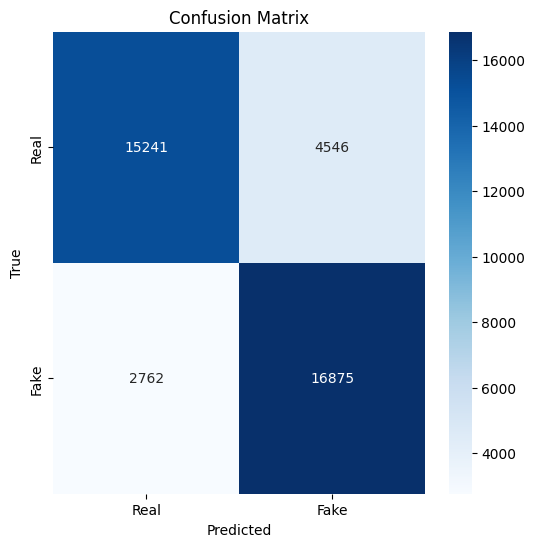

Classification Report:
              precision    recall  f1-score   support

        Real       0.85      0.77      0.81     19787
        Fake       0.79      0.86      0.82     19637

    accuracy                           0.81     39424
   macro avg       0.82      0.81      0.81     39424
weighted avg       0.82      0.81      0.81     39424



In [75]:
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_gen.df['label'].map({'Real': 0, 'Fake': 1}).values[:len(y_pred_classes)]

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['Real', 'Fake']))
